In [4]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from modules.smoothed_target_encoder import SmoothedTargetEncoder
from modules.cyclical_encoder import CyclicalEncoder
from modules.flight_preprocessor import FlightPreprocessor

In [5]:
df_flights = pd.read_csv("./data/flights.csv", low_memory=False)

# Set the columns to lower case
df_flights.columns = df_flights.columns.str.lower()
#df_flights = df_flights.fillna(0)
df_flights['is_delayed'] = (df_flights['arrival_delay'] > 15).astype(int)

In [6]:
df_airports = pd.read_csv("./data/airports.csv", low_memory=False)
df_airports.columns = df_airports.columns.str.lower()
df_airports = df_airports[['iata_code', 'state']]

In [7]:
processor = FlightPreprocessor()
df_flights = processor.preprocess(df_flights)

In [8]:
df_flights = df_flights.merge(
    df_airports,
    how='left',
    left_on='origin_airport',
    right_on='iata_code',
    suffixes=('', '_origin')
)

df_flights = df_flights.rename(columns={'state': 'state_origin'})
df_flights = df_flights.drop(columns=['iata_code'])

df_flights = df_flights.merge(
    df_airports,
    how='left',
    left_on='destination_airport',
    right_on='iata_code',
    suffixes=('', '_dest')
)

df_flights = df_flights.rename(columns={'state': 'state_dest'})
df_flights = df_flights.drop(columns=['iata_code'])

In [9]:
#variable that we know before the flight 
known_variables = [
    'airline', 'origin_airport', 'destination_airport',
    'state_origin', 'state_dest',
    'distance',
    'scheduled_departure', 'scheduled_arrival',
    'day_of_week', 'month', 'year',
    'is_delayed'
]
df_features = df_flights[known_variables].copy()

In [10]:
df_features.head()

,airline,origin_airport,destination_airport,state_origin,state_dest,distance,scheduled_departure,scheduled_arrival,day_of_week,month,year,is_delayed
0,AS,ANC,SEA,AK,WA,1448,2015-01-01 00:05:00,2015-01-01 04:30:00,3,1,2015,0
1,AA,LAX,PBI,CA,FL,2330,2015-01-01 00:10:00,2015-01-01 07:50:00,3,1,2015,0
2,US,SFO,CLT,CA,NC,2296,2015-01-01 00:20:00,2015-01-01 08:06:00,3,1,2015,0
3,AA,LAX,MIA,CA,FL,2342,2015-01-01 00:20:00,2015-01-01 08:05:00,3,1,2015,0
4,AS,SEA,ANC,WA,AK,1448,2015-01-01 00:25:00,2015-01-01 03:20:00,3,1,2015,0


In [12]:
enc_distance = SmoothedTargetEncoder('distance', 'is_delayed')
enc_origin = SmoothedTargetEncoder('origin_airport', 'is_delayed')
enc_destination = SmoothedTargetEncoder('destination_airport', 'is_delayed')
enc_airline = SmoothedTargetEncoder('airline', 'is_delayed')
enc_state_origin = SmoothedTargetEncoder('state_origin', 'is_delayed')
enc_state_dest = SmoothedTargetEncoder('state_dest', 'is_delayed')

df_features['distance'] = enc_distance.fit_transform(df_features)
df_features['origin_airport_encoded'] = enc_origin.fit_transform(df_features)
df_features['destination_airport_encoded'] = enc_destination.fit_transform(df_features)
df_features['airline_encoded'] = enc_airline.fit_transform(df_features)
df_features['state_origin'] = enc_state_origin.fit_transform(df_features)
df_features['state_dest'] = enc_state_dest.fit_transform(df_features)

In [13]:
df_features['scheduled_departure'] = pd.to_datetime(df_features['scheduled_departure'])
df_features['scheduled_arrival']   = pd.to_datetime(df_features['scheduled_arrival'])


# departure
df_features['dep_hour'] = (
    df_features['scheduled_departure'].dt.hour +
    df_features['scheduled_departure'].dt.minute / 60
)
df_features['dep_dayofyear'] = df_features['scheduled_departure'].dt.dayofyear

#arrival
df_features['arr_hour'] = (
    df_features['scheduled_arrival'].dt.hour +
    df_features['scheduled_arrival'].dt.minute / 60
)
df_features['arr_dayofyear'] = df_features['scheduled_arrival'].dt.dayofyear


dep_enc_day = CyclicalEncoder('dep_dayofyear', period=365)
dep_enc_hour = CyclicalEncoder('dep_hour', period=24)
arr_enc_day = CyclicalEncoder('arr_dayofyear', period=365)
arr_enc_hour = CyclicalEncoder('arr_hour', period=24)

df_features = dep_enc_day.fit_transform(df_features)
df_features = dep_enc_hour.fit_transform(df_features)
df_features = arr_enc_day.fit_transform(df_features)
df_features = arr_enc_hour.fit_transform(df_features)

In [14]:
df_features.columns

Index(['airline', 'origin_airport', 'destination_airport', 'state_origin',
       'state_dest', 'distance', 'scheduled_departure', 'scheduled_arrival',
       'day_of_week', 'month', 'year', 'is_delayed', 'origin_airport_encoded',
       'destination_airport_encoded', 'airline_encoded', 'dep_dayofyear_sin',
       'dep_dayofyear_cos', 'dep_hour_sin', 'dep_hour_cos',
       'arr_dayofyear_sin', 'arr_dayofyear_cos', 'arr_hour_sin',
       'arr_hour_cos'],
      dtype='object')

In [16]:
final_features = [
    'state_origin', 'state_dest', 'distance',
    'origin_airport_encoded', 'destination_airport_encoded', 'airline_encoded', 
    'dep_dayofyear_sin', 'dep_dayofyear_cos',
    'dep_hour_sin', 'dep_hour_cos', 
    'arr_dayofyear_sin', 'arr_dayofyear_cos', 
    'arr_hour_sin', 'arr_hour_cos',
    'is_delayed'
]

df_processed = df_features[final_features].copy()

In [17]:
df_processed.head()

,state_origin,state_dest,distance,origin_airport_encoded,destination_airport_encoded,airline_encoded,dep_dayofyear_sin,dep_dayofyear_cos,dep_hour_sin,dep_hour_cos,arr_dayofyear_sin,arr_dayofyear_cos,arr_hour_sin,arr_hour_cos,is_delayed
0,0.137861,0.156151,0.136895,0.117408,0.155344,0.122971,0.017213,0.999852,0.021815,0.999762,0.017213,0.999852,0.923880,0.382683,0
1,0.182288,0.193354,0.217552,0.198610,0.216695,0.172742,0.017213,0.999852,0.043619,0.999048,0.017213,0.999852,0.887011,-0.461749,0
2,0.181923,0.161174,0.171443,0.192121,0.148261,0.175863,0.017213,0.999852,0.087156,0.996195,0.017213,0.999852,0.852640,-0.522499,0
3,0.181923,0.193603,0.208143,0.197842,0.196137,0.172308,0.017213,0.999852,0.087156,0.996195,0.017213,0.999852,0.854912,-0.518773,0
4,0.155900,0.156529,0.134921,0.159041,0.166936,0.123137,0.017213,0.999852,0.108867,0.994056,0.017213,0.999852,0.766044,0.642788,0


In [18]:
df_processed['is_delayed'].value_counts(normalize=True)

is_delayed
0    0.824113
1    0.175887
Name: proportion, dtype: float64

In [19]:
X = df_processed.drop(columns=['is_delayed'])
y = df_processed['is_delayed']

In [20]:
"""
#### Treinamento da imagem 2
# split treino/teste (o seu)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# split interno para early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# desbalanceamento (se y for 0/1)
pos = float(y_tr.sum())
neg = float(len(y_tr) - y_tr.sum())
scale_pos_weight = neg / pos if pos > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=5000,            # alto + early stopping decide o ponto
    learning_rate=0.05,           # costuma performar melhor que 0.01 com ES
    max_depth=4,                  # experimente 3–5
    min_child_weight=5,           # experimente 1, 5, 10
    subsample=0.8,                # experimente 0.7–1.0
    colsample_bytree=0.8,         # experimente 0.7–1.0
    reg_lambda=1.0,
    reg_alpha=0.0,                # experimente 0–0.5
    gamma=0.0,                    # experimente 0–1
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=100,    # no construtor (xgboost recente)
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=50
)

# métricas
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print("Best iteration:", xgb_model.best_iteration)
print("Best score (val AUC):", xgb_model.best_score)
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))"""

'\n# split treino/teste (o seu)\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42, stratify=y\n)\n\n# split interno para early stopping\nX_tr, X_val, y_tr, y_val = train_test_split(\n    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train\n)\n\n# desbalanceamento (se y for 0/1)\npos = float(y_tr.sum())\nneg = float(len(y_tr) - y_tr.sum())\nscale_pos_weight = neg / pos if pos > 0 else 1.0\n\nxgb_model = xgb.XGBClassifier(\n    objective="binary:logistic",\n    eval_metric="auc",\n    n_estimators=5000,            # alto + early stopping decide o ponto\n    learning_rate=0.05,           # costuma performar melhor que 0.01 com ES\n    max_depth=4,                  # experimente 3–5\n    min_child_weight=5,           # experimente 1, 5, 10\n    subsample=0.8,                # experimente 0.7–1.0\n    colsample_bytree=0.8,         # experimente 0.7–1.0\n    reg_lambda=1.0,\n    reg_alpha=0.0,                # experimente 0–0.5\n  

In [21]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
"""scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)"""

'scaler = RobustScaler()\nX_train_scaled = scaler.fit_transform(X_train2)\nX_test_scaled = scaler.transform(X_test2)'

In [23]:
"""feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)"""

'feature_names = X_train.columns.tolist()\nX_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)\nX_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)'

In [24]:
xgb_model2 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
#     scale_pos_weight=2,
    n_estimators=5000,
    learning_rate=0.01,
    subsample=0.6,
    max_depth=5,
    early_stopping_rounds=100,
    random_state=42
)

In [25]:
xgb_model2.fit(
    X_train2,
    y_train2,
    eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
)

[0]	validation_0-auc:0.64404	validation_1-auc:0.64433
[1]	validation_0-auc:0.64523	validation_1-auc:0.64539
[2]	validation_0-auc:0.64678	validation_1-auc:0.64693
[3]	validation_0-auc:0.64756	validation_1-auc:0.64766
[4]	validation_0-auc:0.64823	validation_1-auc:0.64833
[5]	validation_0-auc:0.64901	validation_1-auc:0.64908
[6]	validation_0-auc:0.64932	validation_1-auc:0.64938
[7]	validation_0-auc:0.64930	validation_1-auc:0.64941
[8]	validation_0-auc:0.64943	validation_1-auc:0.64949
[9]	validation_0-auc:0.64988	validation_1-auc:0.64989
[10]	validation_0-auc:0.65007	validation_1-auc:0.65009
[11]	validation_0-auc:0.65024	validation_1-auc:0.65025
[12]	validation_0-auc:0.65041	validation_1-auc:0.65037
[13]	validation_0-auc:0.65075	validation_1-auc:0.65070
[14]	validation_0-auc:0.65080	validation_1-auc:0.65080
[15]	validation_0-auc:0.65195	validation_1-auc:0.65187
[16]	validation_0-auc:0.65255	validation_1-auc:0.65249
[17]	validation_0-auc:0.65249	validation_1-auc:0.65244
[18]	validation_0-au

C:\Users\guide\PycharmProjects\fiap-machine-learning-tech-challenge-3\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [27]:
# Predict probabilities for AUC calculation
y_pred_proba = xgb_model2.predict_proba(X_test2)[:, 1]

# Predict class labels
y_pred = xgb_model2.predict(X_test2)

# Evaluate performance
accuracy = accuracy_score(y_test2, y_pred)
auc_score = roc_auc_score(y_test2, y_pred_proba)
cm2 = confusion_matrix(y_test2, y_pred)

print("\n### Model Evaluation Results (Test Set) ###")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {auc_score:.4f}")
print("\nConfusion Matrix:")
print(cm2)


### Model Evaluation Results (Test Set) ###
Accuracy: 0.8276
ROC-AUC Score: 0.7221

Confusion Matrix:
[[953912   5204]
 [195427   9273]]


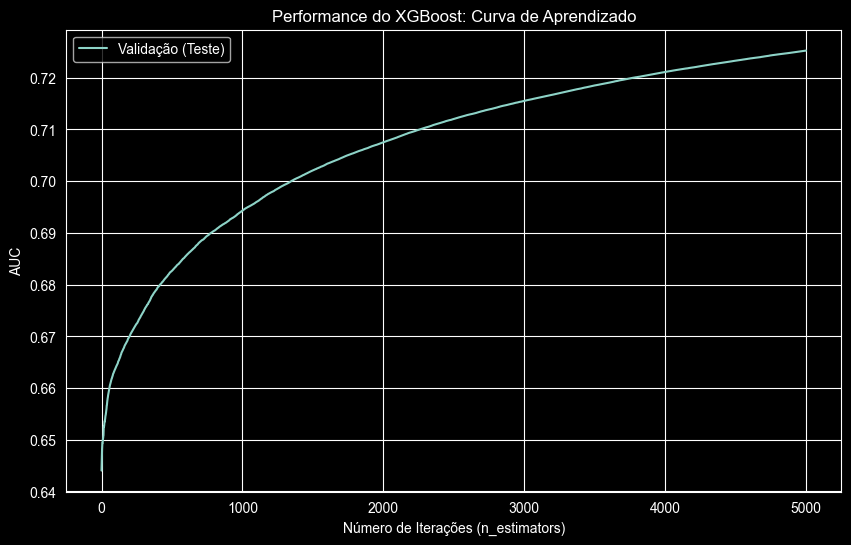

In [28]:
# 1. Recupera o histórico de resultados do modelo treinado
results = xgb_model2.evals_result()

# 2. Define o eixo X (número de iterações/árvores)
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# 3. Plota o gráfico
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['auc'], label='Validação (Teste)')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Número de Iterações (n_estimators)')
plt.title('Performance do XGBoost: Curva de Aprendizado')
plt.grid(True)
plt.show()